In [1]:
from utils_v1 import *

from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    DeforestationTime, MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates, 
    MT, MTDeforestationTime, MTMultipleDates
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
import matplotlib.pyplot as plt
import matplotlib

from tifffile import imsave
import src.rasterTools as rasterTools


In [2]:
addPastDeforestationInput = True

# threshold_uncertainty = 0.15

# dataset = PAMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)
dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
 	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

save_probabilities = True
loadInference = True

if type(dataset) == PAMultipleDates:
	exp = 11 # Multiple dates. using fixed fixed past deforestation distance
	exp = 22
	exp = 50
	exp = 52
	# exp = 54
	exp = 56
	exp = 58
	# exp = 63
	# exp = 52
	# exp = 64
	# exp = 66
	exp = 66
	exp = 68
	# exp = 69
	# exp = 70
	exp = 72
if type(dataset) == MTDeforestationTime:
	exp = 28
elif type(dataset) == PAMultipleDates:
	# exp = 72 # train 2015-2018
	# exp = 69 # train 2016-2018
	# exp = 70 # train 2017-2018
	
	
	exp = 103 # train 2018-2019. test 2018-2019
elif type(dataset) == MTMultipleDates:
	exp = 116

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [3]:
exp

116

In [4]:
if exp == 103:
    threshold_uncertainty = 0.123
if exp == 116:
    threshold_uncertainty = 0.118


In [5]:
threshold_uncertainty

0.118

In [6]:
exp

116

In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


(-0.5, 10419.5, 16794.5, -0.5)

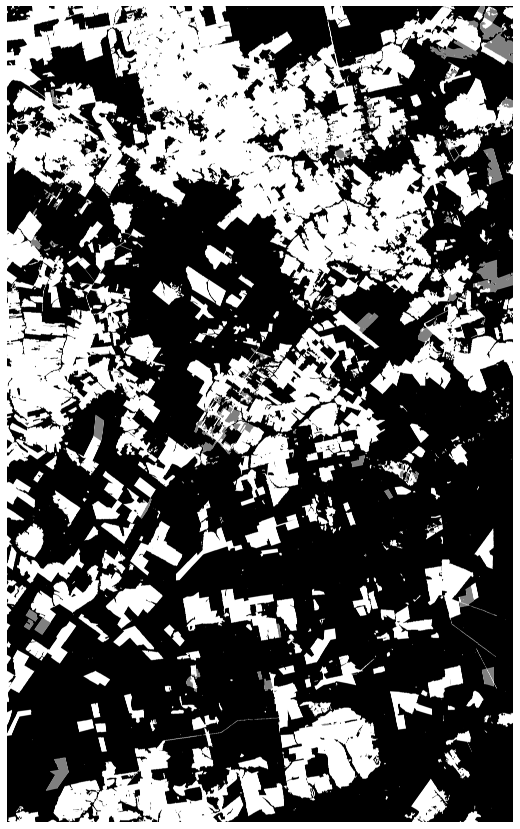

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [10]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [11]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [12]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [13]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [14]:
if not issubclass(type(dataset), DeforestationTime):
    patchesHandler.dataset.image_channels[-1]

In [15]:
if issubclass(type(dataset), MultipleDates):
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [16]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp116'

In [17]:
channels

21

In [18]:
image_stack.shape

(16795, 10420, 21)

In [19]:
if issubclass(type(dataset), MultipleDates):
	channels = patchesHandler.input_image_shape
	# image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	# label_mask = label_mask[...,-1]

In [20]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-5.0 -12.0


In [21]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp116/models/resunet_0.h5'


In [22]:
del image1_pad


In [23]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [24]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [25]:
label_mask.shape

(16795, 10420)

In [26]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]

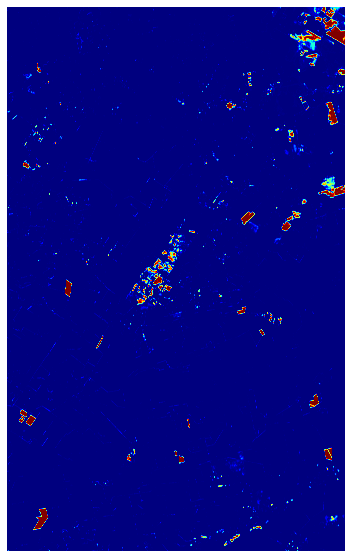

In [27]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [28]:
print(label_mask.shape)

(16795, 10420)


In [29]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))


In [30]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [31]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [32]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [33]:
print(mean_prob.shape)

# threshold = 0.420339
threshold = 0.5

predicted = np.zeros_like(mean_prob)

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

(16795, 10420)
(array([0., 1.], dtype=float32), array([172561827,   2442073], dtype=int64))


(-0.5, 10419.5, 16794.5, -0.5)

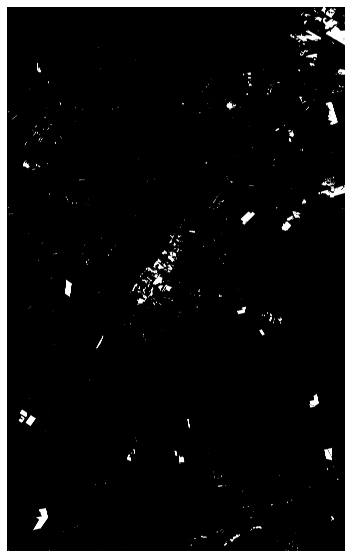

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(predicted, cmap = plt.cm.gray)
plt.axis('off')

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [36]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.016250003
    np.max(prob_rec): 1.0


(0.0, 0.016250003, 1.0)

In [37]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [38]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0073983273
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.007939026
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [39]:
import utils_v1
label_mask_test = label_mask[mask_amazon_ts == 1]
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
y_pred = pred_entropy_test

In [40]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): 9.489219e-12
    np.mean(y_pred): 0.010580233
    np.max(y_pred): 0.36787948


(9.489219e-12, 0.010580233, 0.36787948)

In [41]:
importlib.reload(_metrics)


predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44657480,)


(44657480,)

In [42]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43267728,  1389752], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109996296,   2271496,  62736108], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43267728,  1389752], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109996296,   2271496,  62736108], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [43]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    # total_test_area = mask_test.copy()
    # total_test_area[label_mask == 2] = 0
    total_test_area = mask_test[label_mask != 2] 
    total_test_area = total_test_area[total_test_area == 1]
    ic(uncertainty_mask.flatten().shape, total_test_area.shape)
    percentage = np.count_nonzero(uncertainty_mask.flatten()) / len(total_test_area.flatten())
    return total_test_area, percentage

ic(predicted_thresholded.shape, label_mask.shape, mask_amazon_ts.shape, label_mask.flatten().shape)
total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| predicted_thresholded.shape: (44657480,)
    label_mask.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.flatten().shape: (175003900,)
ic| uncertainty_mask.flatten().shape: (44657480,)
    total_test_area.shape: (44657480,)
ic| percentage: 0.031120251299446365


0.031120251299446365

In [44]:

pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)



uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1

ignoreSmallPolygons = False
if ignoreSmallPolygons == True:
    min_polygon_area = 625 # pixels
    ic(np.unique(uncertainty_mask, return_counts=True))

    uncertainty_mask_without_small_polygons = skimage.morphology.area_opening(uncertainty_mask, 
        area_threshold = min_polygon_area, connectivity=1)

    
ic(np.unique(uncertainty_mask, return_counts=True))



ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64))


(array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64))

In [45]:
# cv2.imwrite("uncertainty_mask_without_small_polygons.png", uncertainty_mask_without_small_polygons*255)
# cv2.imwrite("uncertainty_mask.png", uncertainty_mask*255)


In [46]:
# ic(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


In [47]:
# plt.figure(figsize=(10,10))
# plt.imshow(image_stack[...,[13,12,11]])
# plt.axis('off')



In [48]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", image_stack[...,[3,2,1]])
## cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))
# cv2.imwrite("MT_sentinel2_t1_rgb.png", (image_stack[...,[13,12,11]]*255).astype(np.uint8))


In [49]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))

In [50]:
ic(pred_entropy_unpad.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [51]:
'''
def getUncertaintyMask(uncertainty):

    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)
    uncertainty_mask[uncertainty >= 0.15] = 1
    return uncertainty_mask
def maskOutPastDeforestation(uncertainty_mask, label_mask):
    uncertainty_mask[label_mask == 2] = 0
    return uncertainty_mask

uncertainty_mask = getUncertaintyMask(pred_entropy_unpad)
uncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)
ic(np.unique(uncertainty_mask, return_counts=True))
'''

'\ndef getUncertaintyMask(uncertainty):\n\n    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)\n    uncertainty_mask[uncertainty >= 0.15] = 1\n    return uncertainty_mask\ndef maskOutPastDeforestation(uncertainty_mask, label_mask):\n    uncertainty_mask[label_mask == 2] = 0\n    return uncertainty_mask\n\nuncertainty_mask = getUncertaintyMask(pred_entropy_unpad)\nuncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)\nic(np.unique(uncertainty_mask, return_counts=True))\n'

In [52]:
'''
uncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]
label_test = label_mask[mask_amazon_ts==1]

uncertainty_mask_test = uncertainty_mask_test[label_test!=2]

ic(uncertainty_mask_test.shape)
'''

'\nuncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]\nlabel_test = label_mask[mask_amazon_ts==1]\n\nuncertainty_mask_test = uncertainty_mask_test[label_test!=2]\n\nic(uncertainty_mask_test.shape)\n'

In [53]:
prob_rec.shape

(10, 16800, 10432, 1)

(-0.5, 10431.5, 16799.5, -0.5)

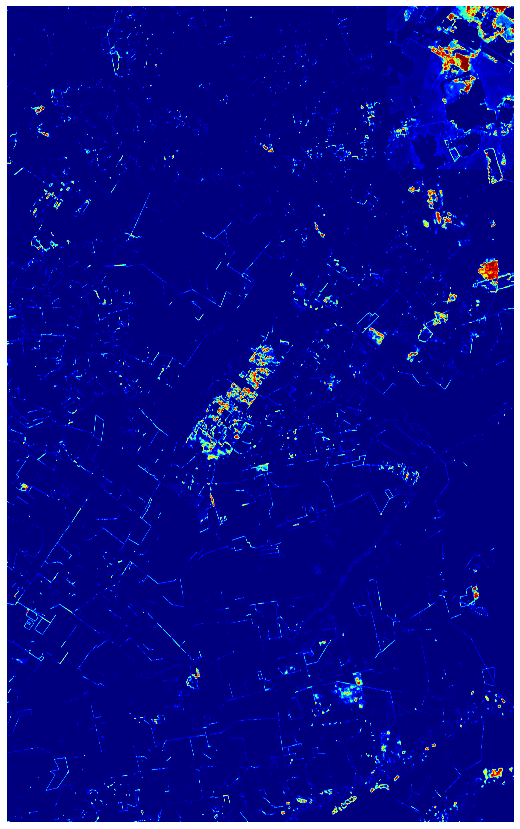

In [54]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


In [55]:
np.mean(pred_entropy)

0.007939026

In [56]:
# mean_prob.shape
pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].shape

(16795, 10420)

In [57]:
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.007939026
    np.max(pred_entropy): 0.36787948


(-0.0, 0.007939026, 0.36787948)

In [58]:
predicted = np.zeros_like(mean_prob).astype(np.uint8)
threshold = 0.5
predicted[mean_prob>=threshold] = 1
min_polygon_area = 625
predicted_without_small_polygons = skimage.morphology.area_opening(predicted, 
        area_threshold = min_polygon_area, connectivity=1)

predicted_small_polygons = predicted - predicted_without_small_polygons


In [59]:
pred_entropy_to_show[predicted_small_polygons == 1] = 0
ic(pred_entropy_to_show.shape)

ic| pred_entropy_to_show.shape: (16795, 10420)


(16795, 10420)

(-0.5, 10419.5, 16794.5, -0.5)

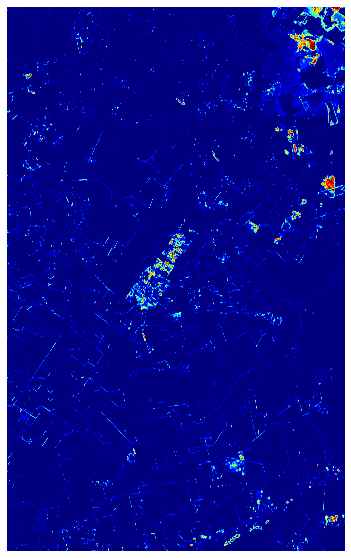

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


In [61]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.007249347
    np.max(pred_entropy_to_show): 0.36787948


(0.0, 0.007249347, 0.36787948)

In [62]:

georreferenced_save = False

In [63]:
import utils_v1
import rasterio

if georreferenced_save == True:
    georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')

In [64]:
if georreferenced_save == True:
    georref_im.shape

In [65]:
ic(pred_entropy_unpad.shape, pred_entropy.shape)
ic(predicted.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (16795, 10420)
    pred_entropy.shape: (16800, 10432)
ic| predicted.shape: (16795, 10420), label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [66]:
prediced_to_show = predicted.copy()
prediced_to_show[label_mask == 2] = 0

label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

false_positive_mask = prediced_to_show - label_mask_current_deforestation
false_positive_mask = (false_positive_mask + 1).astype(np.int8)
ic(np.unique(false_positive_mask, return_counts=True))

ic| np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   283319, 174266685,    453896], dtype=int64))


(array([0, 1, 2], dtype=int8),
 array([   283319, 174266685,    453896], dtype=int64))

In [67]:
if georreferenced_save == True:
    original_im_path = 'D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif'

## Save georreferenced images

In [68]:
if georreferenced_save == True:

    pred_entropy_to_show_pad = rasterTools.padForGeorreferencing(pred_entropy_to_show)

    ic(np.min(pred_entropy_to_show_pad), np.mean(pred_entropy_to_show_pad), np.max(pred_entropy_to_show_pad))

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pred_entropy_to_show_pad, cmap='jet')
    plt.axis('off')

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_uncertainty_georreferenced.tif'
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(pred_entropy_to_show_pad, axis=0).astype(np.float32), produced_im_path, bands = 1,
                    nodata=-1)

In [69]:
if georreferenced_save == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_false_positive_mask_georreferenced.tif'
    false_positive_mask_pad = rasterTools.padForGeorreferencing(false_positive_mask, pad_value = 255)
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(false_positive_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

In [70]:
if georreferenced_save == True:

    label_mask_pad = rasterTools.padForGeorreferencing(label_mask, pad_value = 255)
    label_mask_pad.dtype

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_ground_truth_georreferenced.tif'
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(label_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

    predicted_pad = rasterTools.padForGeorreferencing(predicted, pad_value = 255)
    predicted_pad.dtype
    predicted_pad[label_mask_pad == 2] = 2

    ic(np.unique(predicted_pad, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_predicted_georreferenced.tif'
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(predicted_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

                

In [71]:

if georreferenced_save == True:

    im_t0_pad = rasterTools.padForGeorreferencingChannels(image_stack[...,[3,2,1]])
    im_t0_pad = np.transpose(im_t0_pad, (2, 0, 1))
    print(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2019_rgb_georreferenced.tif'
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t0_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)

    im_t1_pad = rasterTools.padForGeorreferencingChannels(image_stack[...,[13,12,11]])
    im_t1_pad = np.transpose(im_t1_pad, (2, 0, 1))
    print(im_t1_pad.shape)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2020_rgb_georreferenced.tif'
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t1_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)
    

In [72]:
uncertainty_mask.dtype

dtype('int8')

In [73]:


if georreferenced_save == True:
    uncertainty_mask_pad = rasterTools.padForGeorreferencingChannels(uncertainty_mask)
    uncertainty_mask_pad = np.transpose(uncertainty_mask_pad, (2, 0, 1))

    uncertainty_mask_without_small_polygons_pad = rasterTools.padForGeorreferencingChannels(
        uncertainty_mask_without_small_polygons)
    uncertainty_mask_without_small_polygons_pad = np.transpose(
        uncertainty_mask_without_small_polygons_pad, (2, 0, 1))

(-0.5, 10419.5, 16794.5, -0.5)

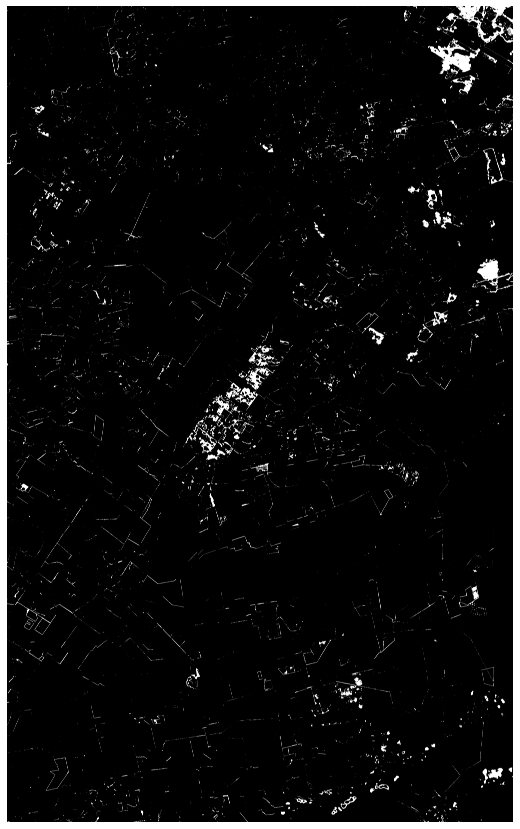

In [74]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [75]:
ic(np.unique(uncertainty_mask, return_counts=True))

ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64))


(array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64))

In [76]:
# contours, _ = cv2.findContours(uncertainty_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);

In [77]:
# len(contours)

In [78]:
# for con in contours:
#     area = cv2.contourArea(con);
#     print(area)

In [79]:
connectivity = 4  
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    uncertainty_mask, connectivity, cv2.CV_32S)


In [80]:
ic(num_labels)

ic| num_labels: 16065


16065

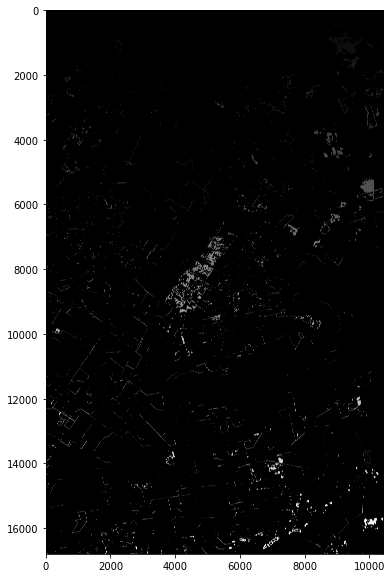

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap = plt.cm.gray)

In [82]:
area = stats[1:,-1]

In [83]:
stats[44:55]

array([[ 222,    4,    2,    3,    3],
       [6856,    5,    1,    1,    1],
       [8630,    5,    1,    2,    2],
       [1264,    7,    2,    8,   12],
       [2495,    6,    9,    8,   25],
       [ 227,    8,    3,    1,    3],
       [3405,    9,    3,   13,   30],
       [3419,    8,    2,    3,    5],
       [8296,    8,    1,    1,    1],
       [8641,    8,    1,    1,    1],
       [ 250,   11,    4,    2,    5]], dtype=int32)

In [84]:
ic(np.min(area),np.mean(area),np.max(area))

ic| np.min(area): 1
    np.mean(area): 237.68974103585657
    np.max(area): 282682


(1, 237.68974103585657, 282682)

In [85]:
np.argmax(area)

36

In [86]:
area.shape

(16064,)

In [87]:
if issubclass(type(dataset), MT):
    bin_n = 435
    bin_n = 452

elif issubclass(type(dataset), PA):
    bin_n = 140
    bin_n = 113

bin_n

452

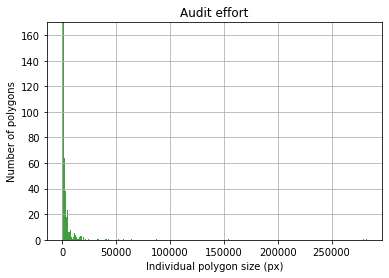

In [88]:
import matplotlib.pyplot as plt
# bin_n = 450
n, bins, patches = plt.hist(area, bin_n, facecolor='g', alpha=0.75)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
plt.title('Audit effort')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(-100, 2000)
plt.ylim(0, 170)
plt.grid(True)
plt.show()

In [89]:
# print(bins)

In [90]:
# ic(bins, bins[2]-bins[1], bins[3]-bins[2], bins[4]-bins[3])
bin_size = round(bins[2]-bins[1], 1)
ic(bin_size)

ic| bin_size: 625.4


625.4

In [91]:
import pdb
def getBinAreaSum(areas, bin_n, bin_size):
    areaSumPerBin = []
    for bin_id in range(bin_n):
        areaSum = 0
        for area in areas:
            if area > bin_size * bin_id and area < bin_size * (bin_id + 1):
                areaSum = areaSum + area
                # print(areaSum)
                # pdb.set_trace()
        areaSumPerBin.append(areaSum)
    return areaSumPerBin
        


areaSumPerBin = getBinAreaSum(area, bin_n, bin_size)    
ic(areaSumPerBin)

ic| areaSumPerBin: [641458,
                    303825,
                    209578,
                    140595,
                    106659,
                    86719,
                    72163,
                    108756,
                    26328,
                    36469,
                    39453,
                    36089,
                    61931,
                    17261,
                    8769,
                    38614,
                    20762,
                    54220,
                    35243,
                    48577,
                    25881,
                    13290,
                    14168,
                    14828,
                    15277,
                    31592,
                    49365,
                    0,
                    53144,
                    0,
                    19074,
                    39007,
                    0,
                    0,
                    21827,
                    0,
                    22705,
                

[641458,
 303825,
 209578,
 140595,
 106659,
 86719,
 72163,
 108756,
 26328,
 36469,
 39453,
 36089,
 61931,
 17261,
 8769,
 38614,
 20762,
 54220,
 35243,
 48577,
 25881,
 13290,
 14168,
 14828,
 15277,
 31592,
 49365,
 0,
 53144,
 0,
 19074,
 39007,
 0,
 0,
 21827,
 0,
 22705,
 0,
 24059,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 32554,
 33750,
 0,
 0,
 0,
 0,
 0,
 0,
 37970,
 0,
 0,
 39490,
 0,
 40773,
 0,
 0,
 42733,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 52333,
 0,
 0,
 0,
 0,
 0,
 0,
 56555,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 64259,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 78770,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 87529,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 97168,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [92]:
bins

array([1.00000000e+00, 6.26400442e+02, 1.25180088e+03, 1.87720133e+03,
       2.50260177e+03, 3.12800221e+03, 3.75340265e+03, 4.37880310e+03,
       5.00420354e+03, 5.62960398e+03, 6.25500442e+03, 6.88040487e+03,
       7.50580531e+03, 8.13120575e+03, 8.75660619e+03, 9.38200664e+03,
       1.00074071e+04, 1.06328075e+04, 1.12582080e+04, 1.18836084e+04,
       1.25090088e+04, 1.31344093e+04, 1.37598097e+04, 1.43852102e+04,
       1.50106106e+04, 1.56360111e+04, 1.62614115e+04, 1.68868119e+04,
       1.75122124e+04, 1.81376128e+04, 1.87630133e+04, 1.93884137e+04,
       2.00138142e+04, 2.06392146e+04, 2.12646150e+04, 2.18900155e+04,
       2.25154159e+04, 2.31408164e+04, 2.37662168e+04, 2.43916173e+04,
       2.50170177e+04, 2.56424181e+04, 2.62678186e+04, 2.68932190e+04,
       2.75186195e+04, 2.81440199e+04, 2.87694204e+04, 2.93948208e+04,
       3.00202212e+04, 3.06456217e+04, 3.12710221e+04, 3.18964226e+04,
       3.25218230e+04, 3.31472235e+04, 3.37726239e+04, 3.43980243e+04,
      

In [93]:
matplotlib.rcParams.update({'font.size': 16})


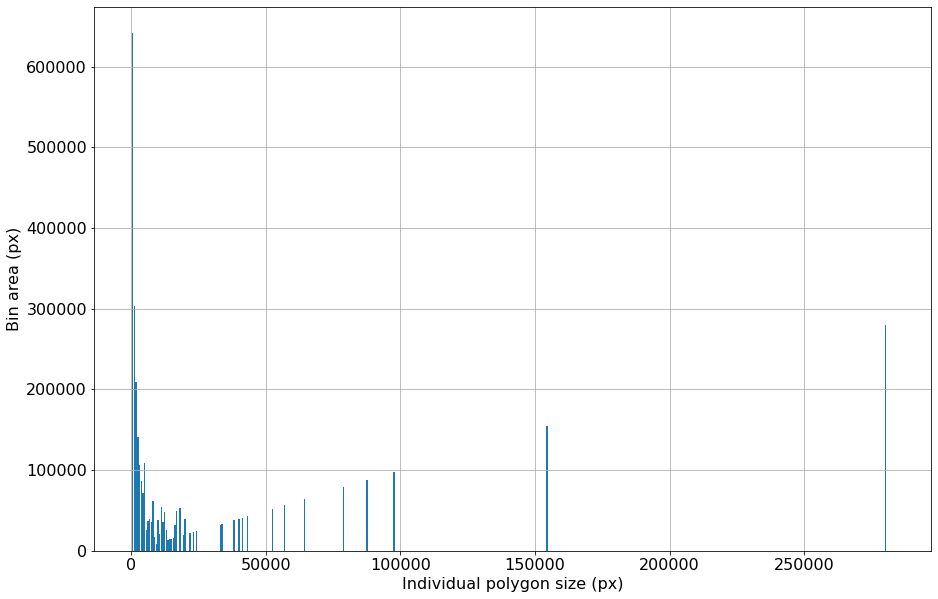

In [94]:

plt.figure(figsize = (15,10))
width = 500
plt.bar(bins[1:], areaSumPerBin, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Bin area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('output/figures/polygon_area_sum_per_bin.png', dpi=150, bbox_inches='tight')

In [95]:
ic(bins.shape, n.shape)

ic| bins.shape: (453,), n.shape: (452,)


((453,), (452,))

In [96]:
ic(np.sum(n))

ic(np.sum(n) - n[0])

ic| np.sum(n): 16064.0
ic| np.sum(n) - n[0]: 740.0


740.0

In [97]:
bins[1:]

array([   626.40044248,   1251.80088496,   1877.20132743,   2502.60176991,
         3128.00221239,   3753.40265487,   4378.80309735,   5004.20353982,
         5629.6039823 ,   6255.00442478,   6880.40486726,   7505.80530973,
         8131.20575221,   8756.60619469,   9382.00663717,  10007.40707965,
        10632.80752212,  11258.2079646 ,  11883.60840708,  12509.00884956,
        13134.40929204,  13759.80973451,  14385.21017699,  15010.61061947,
        15636.01106195,  16261.41150442,  16886.8119469 ,  17512.21238938,
        18137.61283186,  18763.01327434,  19388.41371681,  20013.81415929,
        20639.21460177,  21264.61504425,  21890.01548673,  22515.4159292 ,
        23140.81637168,  23766.21681416,  24391.61725664,  25017.01769912,
        25642.41814159,  26267.81858407,  26893.21902655,  27518.61946903,
        28144.0199115 ,  28769.42035398,  29394.82079646,  30020.22123894,
        30645.62168142,  31271.02212389,  31896.42256637,  32521.82300885,
        33147.22345133,  

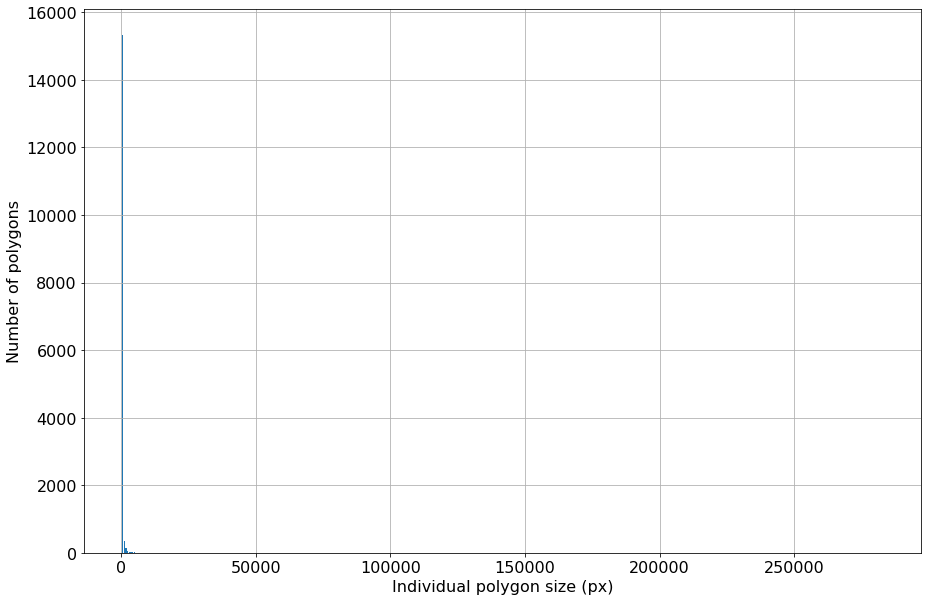

In [98]:

plt.figure(figsize = (15,10))
plt.bar(bins[1:], n, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('output/figures/polygon_bin_area.png', dpi=150, bbox_inches='tight')

In [99]:
def getCumulativeArea(areaSumPerBin):
    cumulativeArea = []
    cumulativeSum = 0
    for areaSum in areaSumPerBin: # for areaSum in areaSumPerBin[::-1]:
        cumulativeSum = cumulativeSum + areaSum
        cumulativeArea.append(cumulativeSum)
    return np.asarray(cumulativeArea) # return np.asarray(cumulativeArea)[::-1]



cumulativeArea = getCumulativeArea(areaSumPerBin)
ic(cumulativeArea.shape)

ic| cumulativeArea.shape: (452,)


(452,)

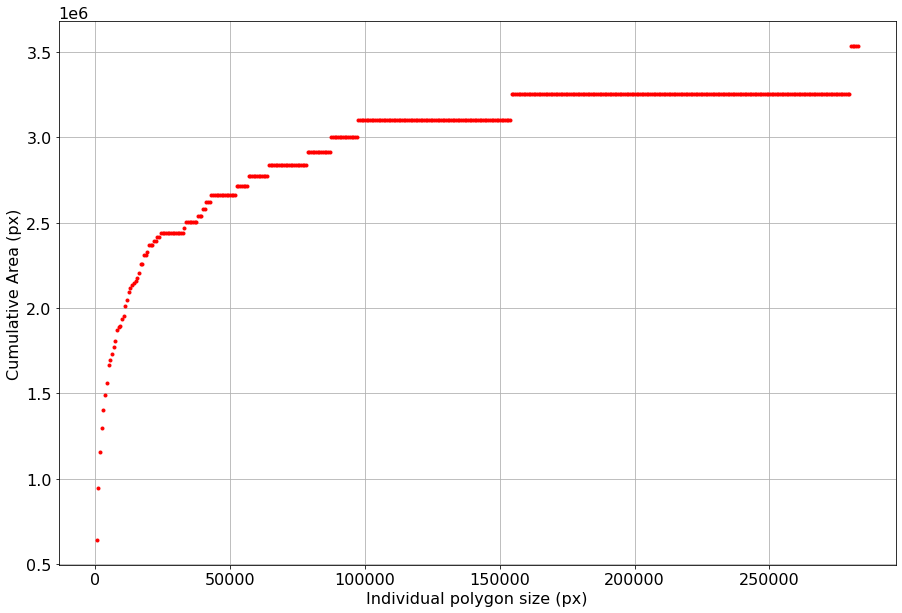

In [100]:

plt.figure(figsize = (15,10))
plt.plot(bins[1:], cumulativeArea,'r.')


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Cumulative Area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('output/figures/polygon_cumulative_area.png', dpi=150, bbox_inches='tight')

In [101]:
cumulativeArea/cumulativeArea[-1]

array([0.18143007, 0.26736398, 0.32664105, 0.36640696, 0.39657441,
       0.42110202, 0.44151262, 0.47227318, 0.4797198 , 0.49003469,
       0.50119359, 0.511401  , 0.52891758, 0.53379968, 0.53627991,
       0.54720149, 0.55307382, 0.56840941, 0.57837755, 0.59211708,
       0.59943726, 0.60319621, 0.60720349, 0.61139744, 0.61571839,
       0.62465387, 0.63861628, 0.63861628, 0.65364753, 0.65364753,
       0.65904243, 0.67007517, 0.67007517, 0.67007517, 0.67624873,
       0.67624873, 0.68267061, 0.68267061, 0.68947546, 0.68947546,
       0.68947546, 0.68947546, 0.68947546, 0.68947546, 0.68947546,
       0.68947546, 0.68947546, 0.68947546, 0.68947546, 0.68947546,
       0.68947546, 0.68947546, 0.69868304, 0.70822889, 0.70822889,
       0.70822889, 0.70822889, 0.70822889, 0.70822889, 0.70822889,
       0.71896833, 0.71896833, 0.71896833, 0.73013769, 0.73013769,
       0.74166993, 0.74166993, 0.74166993, 0.75375654, 0.75375654,
       0.75375654, 0.75375654, 0.75375654, 0.75375654, 0.75375

<Figure size 1080x720 with 0 Axes>

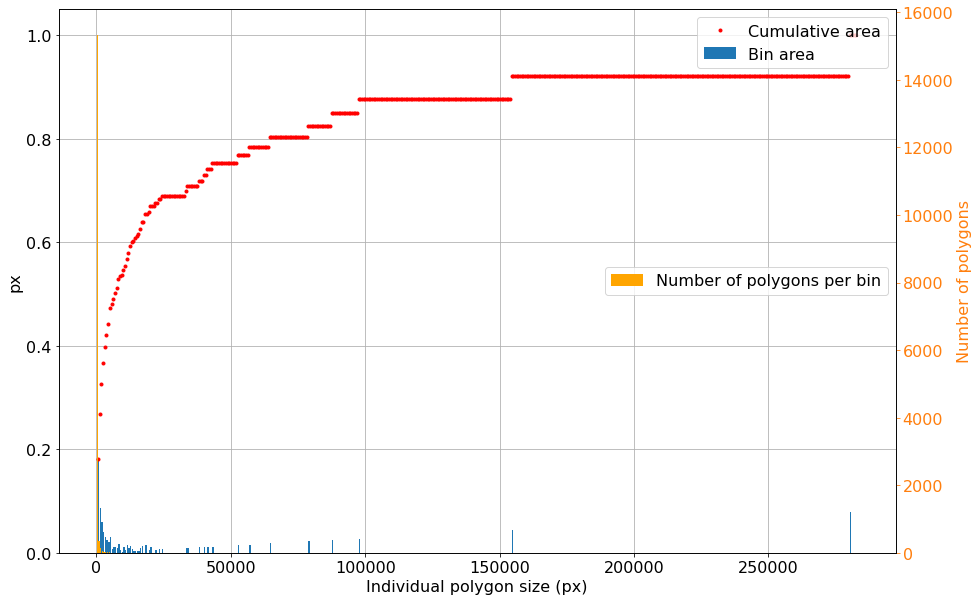

In [102]:


plt.figure(figsize = (15,10))

# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin/cumulativeArea[-1], width, label = 'Bin area')
ax1.plot(bins[1:], cumulativeArea/cumulativeArea[-1],'r.', label = 'Cumulative area')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('px')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('output/figures/polygon_analysis.png', dpi=150, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

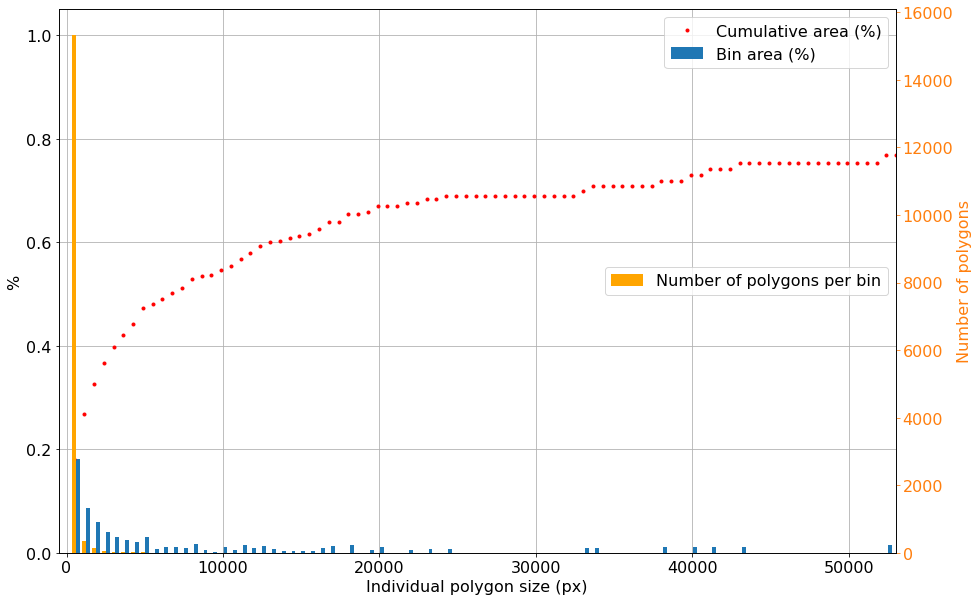

In [103]:


plt.figure(figsize = (15,10))
width = 250
# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin/cumulativeArea[-1], width, label = 'Bin area (%)')
ax1.plot(bins[1:]-width/2, cumulativeArea/cumulativeArea[-1],'r.', label = 'Cumulative area (%)')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('%')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

ax1.set_xlim([-500, 53000])
ax2.set_xlim([-500, 53000])

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('output/figures/polygon_analysis_percentage.png', dpi=150, bbox_inches='tight')

<Figure size 1080x360 with 0 Axes>

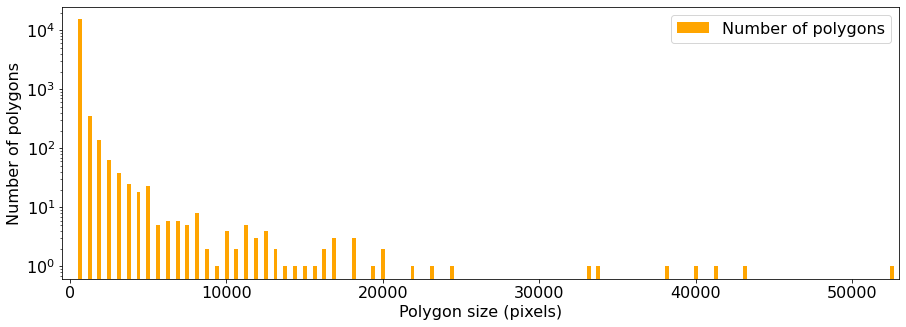

<Figure size 1080x360 with 0 Axes>

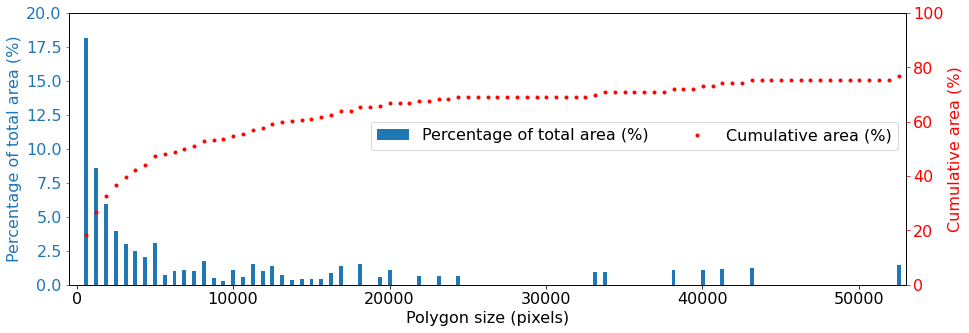

In [104]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize = (15,5))
width = 250
# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)
# fig, ax1 = plt.subplots()
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

ax.bar(bins[1:], n, width, color = 'orange', label = 'Number of polygons', log=True)
ax.legend(loc = 'upper right')
ax.set_ylabel('Number of polygons')
ax.set_xlabel('Polygon size (pixels)')
ax.set_xlim([-500, 53000])

plt.savefig('output/figures/polygon_analysis_percentage_split1.png', dpi=150, bbox_inches='tight')

plt.figure(figsize = (15,5))
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

ax2 = ax.twinx()

ax2.plot(bins[1:], cumulativeArea/cumulativeArea[-1]*100,'r.', label = 'Cumulative area (%)')
ax.bar(bins[1:], areaSumPerBin/cumulativeArea[-1]*100, width, label = 'Percentage of total area (%)')

# ax.plot(bins[1:], cumulativeArea/cumulativeArea[-1],color='r', linestyle='None', label = 'Cumulative area (%)')

ax.set_xlabel('Polygon size (pixels)')
# ax.legend(loc = 'upper right')
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
#           ncol=2)
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6),
#           ncol=2)

# added these three lines
# lns = lns1+lns2
# labs = [l.get_label() for l in lns]
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.6),
          ncol=2)
# fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),
#           ncol=2)


ax.set_ylabel('Percentage of total area (%)', color="C0")
ax.tick_params(axis='y', colors='C0')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_ylabel('Cumulative area (%)', color="r")
ax2.tick_params(axis='y', colors='r', )
# ax2.grid()
          
ax.set_xlim([-500, 53000])

ax.set_ylim([0.0, 20])
ax2.set_ylim([0.0, 100])
plt.savefig('output/figures/polygon_analysis_percentage_split2.png', dpi=150, bbox_inches='tight')

In [105]:
bins

array([1.00000000e+00, 6.26400442e+02, 1.25180088e+03, 1.87720133e+03,
       2.50260177e+03, 3.12800221e+03, 3.75340265e+03, 4.37880310e+03,
       5.00420354e+03, 5.62960398e+03, 6.25500442e+03, 6.88040487e+03,
       7.50580531e+03, 8.13120575e+03, 8.75660619e+03, 9.38200664e+03,
       1.00074071e+04, 1.06328075e+04, 1.12582080e+04, 1.18836084e+04,
       1.25090088e+04, 1.31344093e+04, 1.37598097e+04, 1.43852102e+04,
       1.50106106e+04, 1.56360111e+04, 1.62614115e+04, 1.68868119e+04,
       1.75122124e+04, 1.81376128e+04, 1.87630133e+04, 1.93884137e+04,
       2.00138142e+04, 2.06392146e+04, 2.12646150e+04, 2.18900155e+04,
       2.25154159e+04, 2.31408164e+04, 2.37662168e+04, 2.43916173e+04,
       2.50170177e+04, 2.56424181e+04, 2.62678186e+04, 2.68932190e+04,
       2.75186195e+04, 2.81440199e+04, 2.87694204e+04, 2.93948208e+04,
       3.00202212e+04, 3.06456217e+04, 3.12710221e+04, 3.18964226e+04,
       3.25218230e+04, 3.31472235e+04, 3.37726239e+04, 3.43980243e+04,
      

In [106]:
ic(np.sum(n), np.sum(n[1:]), np.sum(n[2:]))


ic| np.sum(n): 16064.0, np.sum(n[1:]): 740.0, np.sum(n[2:]): 392.0


(16064.0, 740.0, 392.0)

In [107]:
ic(labels.shape, label_mask.shape)

ic| labels.shape: (16795, 10420), label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

(-0.5, 10419.5, 16794.5, -0.5)

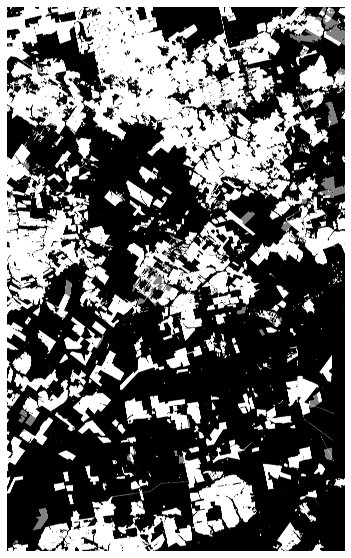

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 10419.5, 16794.5, -0.5)

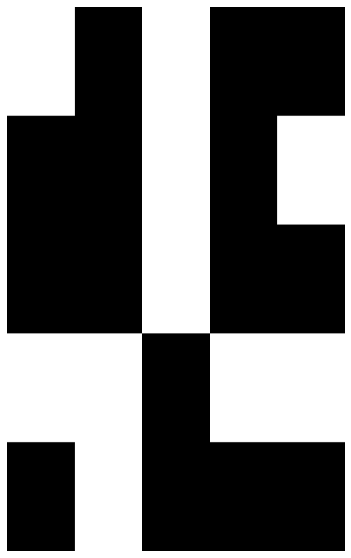

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(mask_amazon_ts, cmap=plt.cm.gray)
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

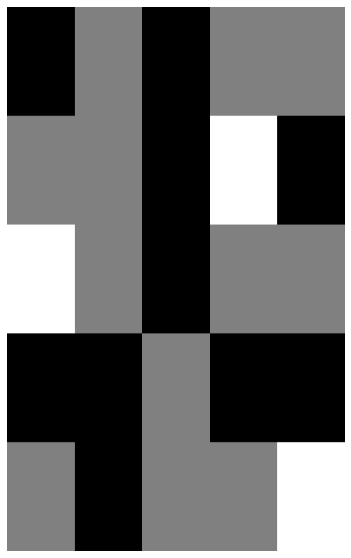

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val, cmap=plt.cm.gray)
plt.axis('off')


In [111]:
label_current_deforestation = label_mask.copy()
label_current_deforestation[label_current_deforestation == 2] = 0
label_current_deforestation = label_current_deforestation.astype(np.bool)

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_11904\2548657025.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_current_deforestation = label_current_deforestation.astype(np.bool)


In [112]:
ic(np.unique(uncertainty_mask, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))


ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109996296,   2271496,  62736108], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=int8), array([171185652,   3818248], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109996296,   2271496,  62736108], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [113]:
'''
plt.figure(figsize=(10,10))
plt.imshow(total_test_area, cmap=plt.cm.gray)
plt.axis('off')
'''

"\nplt.figure(figsize=(10,10))\nplt.imshow(total_test_area, cmap=plt.cm.gray)\nplt.axis('off')\n"

In [114]:
def countIntersectingPolygons(labels, deforestation_polygons):
    ic(np.max(labels))
    count_intersecting_polygons = 0

    for polygon_id in range(np.max(labels)):
        if polygon_id % 500 == 0:
            print(polygon_id, count_intersecting_polygons)
        polygon_mask = labels.copy()
        polygon_mask[polygon_mask != polygon_id] = 0
        polygon_mask = polygon_mask.astype(np.bool)

        
        if np.any(polygon_mask & deforestation_polygons):
            count_intersecting_polygons += 1
    return count_intersecting_polygons
countIntersectingPolygonsFlag = False
if countIntersectingPolygonsFlag == True:
    # count_intersecting_polygons = countIntersectingPolygons(labels, label_current_deforestation)
    count_intersecting_polygons = countIntersectingPolygons(labels, predicted.astype(np.bool))

    ic(count_intersecting_polygons)

In [115]:

if countIntersectingPolygonsFlag == True:
    count_intersecting_polygons/np.max(labels)